In [178]:
#Importing needed modules.
from pycoingecko import CoinGeckoAPI
from pandas import DataFrame , to_datetime
from matplotlib.pyplot import plot , xlabel , ylabel , show , figure , title , legend
from tensorflow.data import Dataset
from tensorflow.keras.layers import Dense , SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import mean_absolute_error , mean_squared_error
#Instancing from 'CoinGeckoAPI' object.
cg = CoinGeckoAPI()

In [179]:
#Getting prices from last 3 months and convert them to a data frame.
coin = cg.get_coin_market_chart_by_id(id='bitcoin',vs_currency='usd',days=90)
df = DataFrame(coin['prices'],columns=[0,'Price'])
df['Time'] = to_datetime(df[0],unit='ms')
df = df.drop([0],axis=1)

In [180]:
df.head()

,Price,Time
0,41202.765309,2023-12-13 10:00:27.993
1,41075.821227,2023-12-13 11:00:03.091
2,40959.774531,2023-12-13 12:00:35.738
3,41124.569953,2023-12-13 13:00:51.623
4,41444.997462,2023-12-13 14:00:49.564


In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Price   2160 non-null   float64       
 1   Time    2160 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.9 KB


In [182]:
df.describe()

,Price,Time
count,2160.000000,2160
mean,47980.023466,2024-01-27 10:12:58.010792448
min,38678.188080,2023-12-13 10:00:27.993000
25%,42617.117672,2024-01-04 21:45:58.984000
50%,43683.899149,2024-01-27 10:30:18.761999872
75%,51572.483388,2024-02-18 22:16:48.238249984
max,72562.578320,2024-03-12 09:56:52
std,8281.962251,NaN


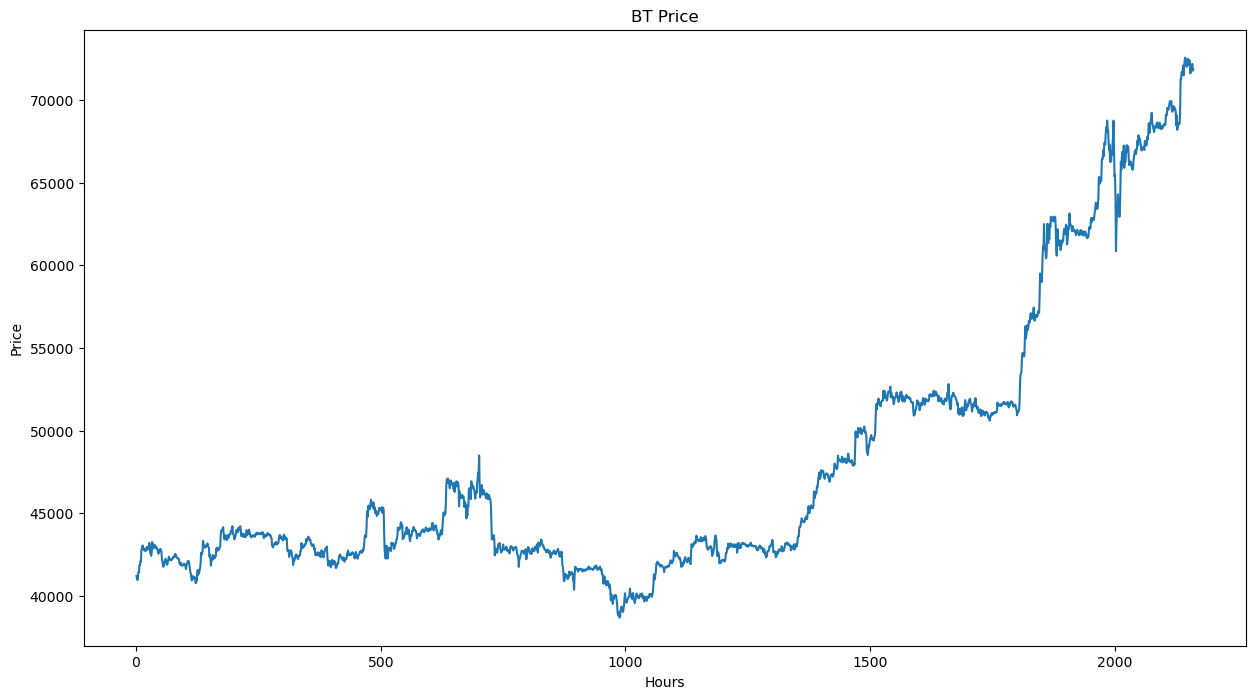

In [183]:
figure(figsize=(15,8))
plot(range(1,len(df.Price)+1),df.Price)
xlabel('Hours')
ylabel('Price')
title('BT Price')
show()

In [184]:
#Splitting data to train and test sets.
idx = (int(input('Enter train size:'))*len(df))//100
xtr = df.Price.to_numpy()[:idx]
xts = df.Price.to_numpy()[idx:]
print(f'Train size: {len(xtr)}\nTest size: {len(xts)}')

Enter train size:80
Train size: 1728
Test size: 432


In [185]:
#Distributing train set to daily arrays.
w_size = 24
sh_size = 100
b_size = w_size*2
dataset_tr = Dataset.from_tensor_slices(xtr)
dataset_tr = dataset_tr.window(w_size,shift=1,drop_remainder=True)
dataset_tr = dataset_tr.flat_map(lambda x : x.batch(w_size))
dataset_tr = dataset_tr.map(lambda x :(x[:-1],x[-1]))
dataset_tr = dataset_tr.shuffle(sh_size)
dataset_tr = dataset_tr.batch(b_size).prefetch(1)

In [186]:
#Distributing test set to daily arrays.
dataset_ts = Dataset.from_tensor_slices(df.Price.to_list())
dataset_ts = dataset_ts.window(w_size,shift=1,drop_remainder=True)
dataset_ts = dataset_ts.flat_map(lambda x : x.batch(w_size))
dataset_ts = dataset_ts.batch(b_size).prefetch(1)

In [187]:
#Creating a model.
model2 = Sequential([SimpleRNN(10,activation='relu',return_sequences=True,input_shape=[None,1]),
                     SimpleRNN(10,activation='relu'),
                     Dense(1)])
model2.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

In [188]:
history = model2.fit(dataset_tr,epochs=100)

Epoch 1/100
36/36 [==============================] - 3s 16ms/step - loss: 737184192.0000 - mae: 26906.7480
Epoch 2/100
36/36 [==============================] - 1s 13ms/step - loss: 103026168.0000 - mae: 8761.6836
Epoch 3/100
36/36 [==============================] - 0s 12ms/step - loss: 82832.8828 - mae: 200.9611
Epoch 4/100
36/36 [==============================] - 0s 11ms/step - loss: 434412.5625 - mae: 506.4744
Epoch 5/100
36/36 [==============================] - 1s 16ms/step - loss: 393232.7500 - mae: 457.7673
Epoch 6/100
36/36 [==============================] - 1s 15ms/step - loss: 409492.0312 - mae: 503.9658
Epoch 7/100
36/36 [==============================] - 1s 17ms/step - loss: 399309.9375 - mae: 492.2745
Epoch 8/100
36/36 [==============================] - 1s 16ms/step - loss: 404632.9688 - mae: 518.5323
Epoch 9/100
36/36 [==============================] - 1s 16ms/step - loss: 442663.8750 - mae: 515.8951
Epoch 10/100
36/36 [==============================] - 1s 14ms/step - loss:

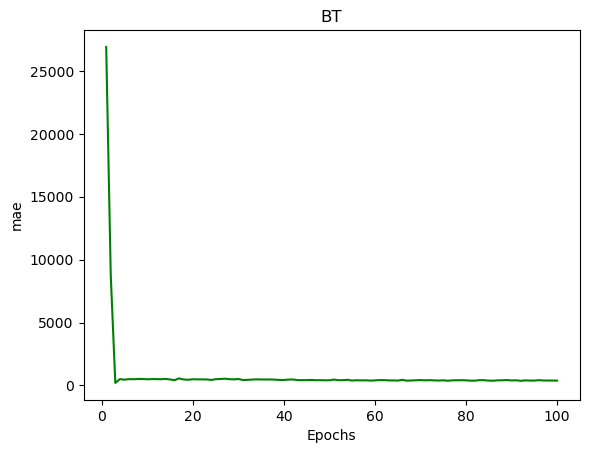

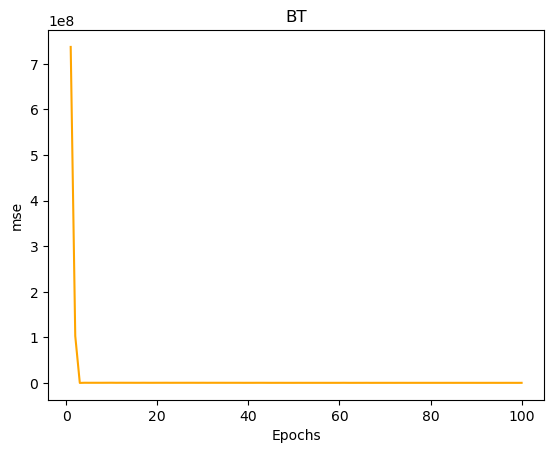

In [189]:
#Visualize models performance.
epoch = range(1,len(history.epoch)+1)
results = history.history
plot(epoch,results['mae'],'green')
xlabel('Epochs')
ylabel('mae')
title('BT')
show()
plot(epoch,results['loss'],'orange')
xlabel('Epochs')
ylabel('mse')
title('BT')
show()

In [190]:
pred = model2.predict(dataset_ts)
new_pred = pred[idx-w_size:-1]

45/45 [==============================] - 1s 10ms/step


In [191]:
message = 'mse on Test set: %f , mae on Test set: %f'%(mean_squared_error(xts,new_pred.ravel()).numpy(),mean_absolute_error(xts,new_pred.ravel()).numpy())
print(message)

mse on Test set: 263255.468750 , mae on Test set: 314.074585


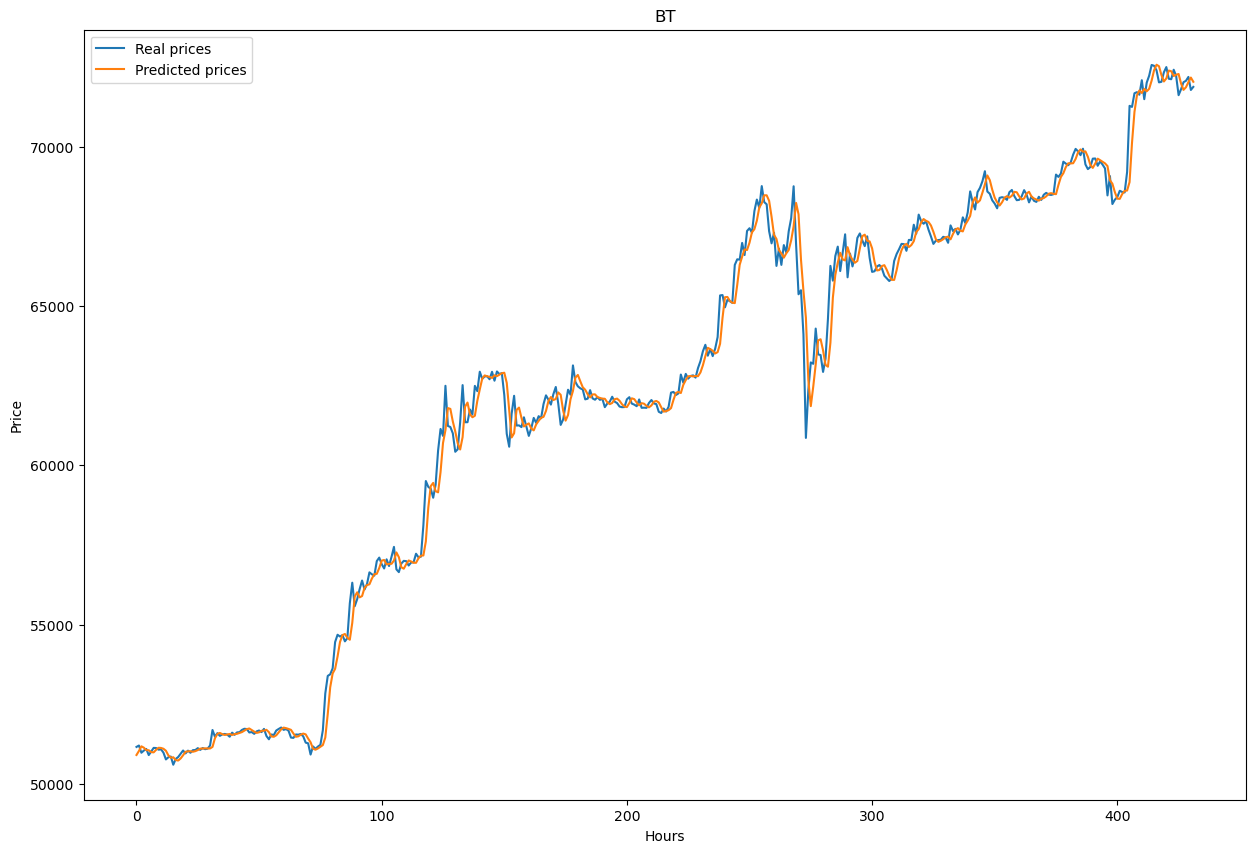

In [192]:
figure(figsize=(15,10))
plot(range(len(xts)),xts)
plot(range(len(xts)),new_pred.ravel())
xlabel('Hours')
ylabel('Price')
legend(['Real prices','Predicted prices'])
title('BT')
show()